In [1]:
%pip install timezonefinder

  Using cached timezonefinder-6.2.0-cp311-cp311-manylinux_2_35_x86_64.whl
  Using cached h3-3.7.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pyspark as pyspark
import pyspark.sql.functions as F
# from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
import pyspark.pandas as ps
from timezonefinder import TimezoneFinder
import numpy as np
import wbgps
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import os

/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
def convert_to_timezone(row):
    return pd.Timestamp(row['datetime'].tz_convert(row['timezone']))

In [4]:
work_period_window = 28
min_periods_over_window = 0.2 #10
min_periods_over_window_work = 0.2 #7
start_hour_day = 5
end_hour_day = 23
min_work_duration = 3600
min_pts_per_stop_location = 2
work_day_fraction = 0.1
work_time_fraction = 0.25
home_work_type = "Dynamic"
min_pings_home_cluster_label = 2
min_days_per_home_location = 0.2
home_period_window = 14
work_activity_average = 60
work_period_window = 28

In [5]:
# create a SparkConf object with the desired configurations
conf = SparkConf().setAppName("MyApp") \
                   .set("spark.sql.execution.arrow.pyspark.enabled", "true") \
                   .set("spark.driver.memory", "15g")

# create a SparkSession object with the SparkConf
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [6]:
tz = False
df = pd.read_parquet("veraset_movement_416.snappy.parquet")
df["epoch_time"] = pd.to_datetime(df["datetime"]).astype(int) // 10**9
df = df.sort_values(["uid","epoch_time"], ascending=True)

In [7]:
df

,uid,datetime,latitude,longitude,id_type,geo_hash,horizontal_accuracy,country,year,date,epoch_time
5240264,0004aa6e1c06916168acc9f08f6102aa90a79c34108011...,2020-01-01 06:28:44+00:00,-6.352578,106.920776,aaid,qqu5c593d,4.0,ID,2020,2020-01-01,1577860124
5240265,0004aa6e1c06916168acc9f08f6102aa90a79c34108011...,2020-01-01 06:33:01+00:00,-6.352578,106.920776,aaid,qqu5c593d,5.0,ID,2020,2020-01-01,1577860381
5240266,0004aa6e1c06916168acc9f08f6102aa90a79c34108011...,2020-01-01 06:53:21+00:00,-6.352578,106.920776,aaid,qqu5c593d,6.0,ID,2020,2020-01-01,1577861601
5240267,0004aa6e1c06916168acc9f08f6102aa90a79c34108011...,2020-01-01 06:54:32+00:00,-6.352578,106.920776,aaid,qqu5c593d,9.0,ID,2020,2020-01-01,1577861672
5240268,0004aa6e1c06916168acc9f08f6102aa90a79c34108011...,2020-01-01 11:01:53+00:00,-6.286839,106.821320,aaid,qqgunz8bt,12.0,ID,2020,2020-01-01,1577876513
...,...,...,...,...,...,...,...,...,...,...,...
4719830,ffa8aab2326246dd56968a7ac7e4530d75129b1e20f0f4...,2020-09-19 02:20:02+00:00,4.659610,-74.114662,aaid,d2g692r25,11.1,CO,2020,2020-09-21,1600482002
4719831,ffa8aab2326246dd56968a7ac7e4530d75129b1e20f0f4...,2020-09-19 03:25:57+00:00,4.659610,-74.114662,aaid,d2g692r25,11.1,CO,2020,2020-09-21,1600485957
4778960,ffa8aab2326246dd56968a7ac7e4530d75129b1e20f0f4...,2020-10-03 21:11:58+00:00,4.656333,-74.114662,aaid,d2g63rxm5,9.6,CO,2020,2020-10-06,1601759518
4788094,ffa8aab2326246dd56968a7ac7e4530d75129b1e20f0f4...,2020-10-05 19:03:24+00:00,4.656333,-74.114662,aaid,d2g63rxm5,11.8,CO,2020,2020-10-08,1601924604


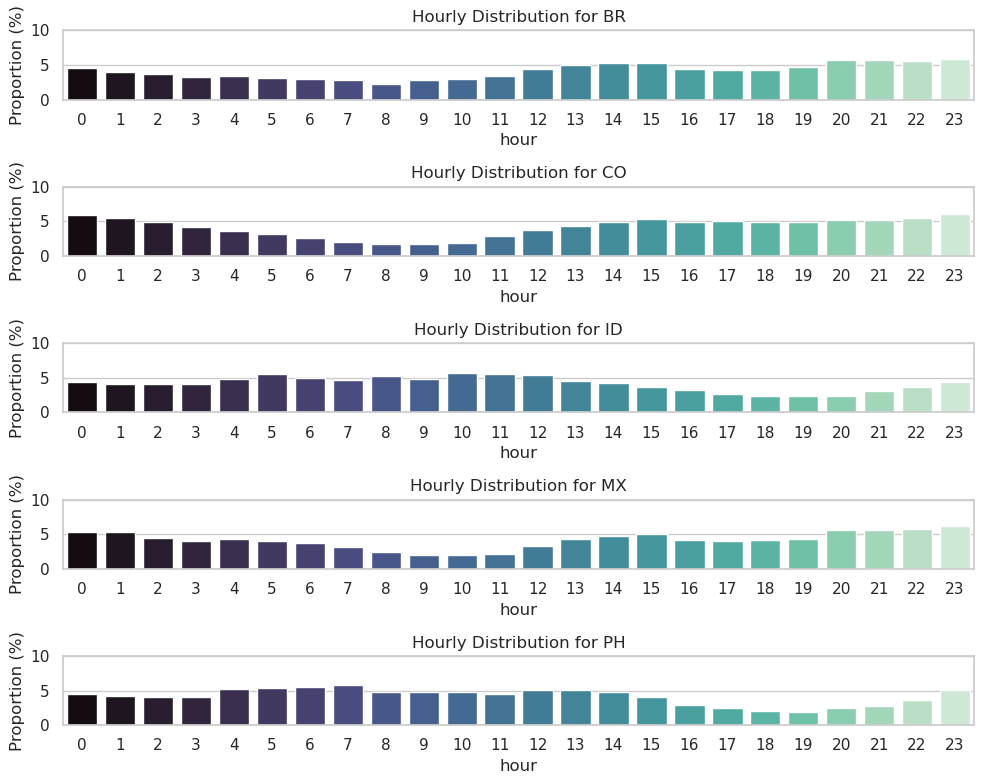

In [8]:
df['hour'] = df['datetime'].dt.hour

# Set the order of countries
country_order = ["BR", "CO", "ID", "MX", "PH"]

# Set the aesthetics for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a subplot for each country
for i, country in enumerate(country_order, 1):
    plt.subplot(len(country_order), 1, i)
    df_country = df[df['country'] == country]
    sns.barplot(x='hour', y='hour', data=df_country, estimator=lambda x: len(x) / len(df_country) * 100, errorbar=None, palette='mako')
    plt.ylabel('Proportion (%)')
    plt.title(f'Hourly Distribution for {country}')
    plt.ylim(0, 10)  # Optional: set the same y-axis scale for all plots

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
tf = TimezoneFinder()
active_user = (df
               .groupby(["country","uid"])
               .size()
               .reset_index()
               .sort_values(0, ascending=False)
               .rename(columns={0:"observations"})
               .drop_duplicates(subset="country"))

country_set = (pd.merge(df,active_user,
                        on=["uid","country"], how="inner")
               .drop_duplicates(subset="uid")
               [["country", "latitude", "longitude"]])

country_set["timezone"] = "UTC"
for index,row in country_set.iterrows():
    country_set["timezone"][index] = (
        tf.timezone_at(lng=country_set.longitude[index],lat=country_set.latitude[index]))

df = pd.merge(df,country_set[["country","timezone"]], on="country", how="left")


/tmp/ipykernel_92/2342621989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_set["timezone"][index] = (


In [10]:
df['local_datetime'] = df.apply(convert_to_timezone, axis=1)

In [11]:
df['local_datetime'] = [pd.Timestamp(x) for x in df.local_datetime]
df["epoch_time"] = df['local_datetime'].apply(lambda x: int(x.tz_localize(None).timestamp()))

In [12]:
df = df.sort_values(["uid","epoch_time"], ascending=True)

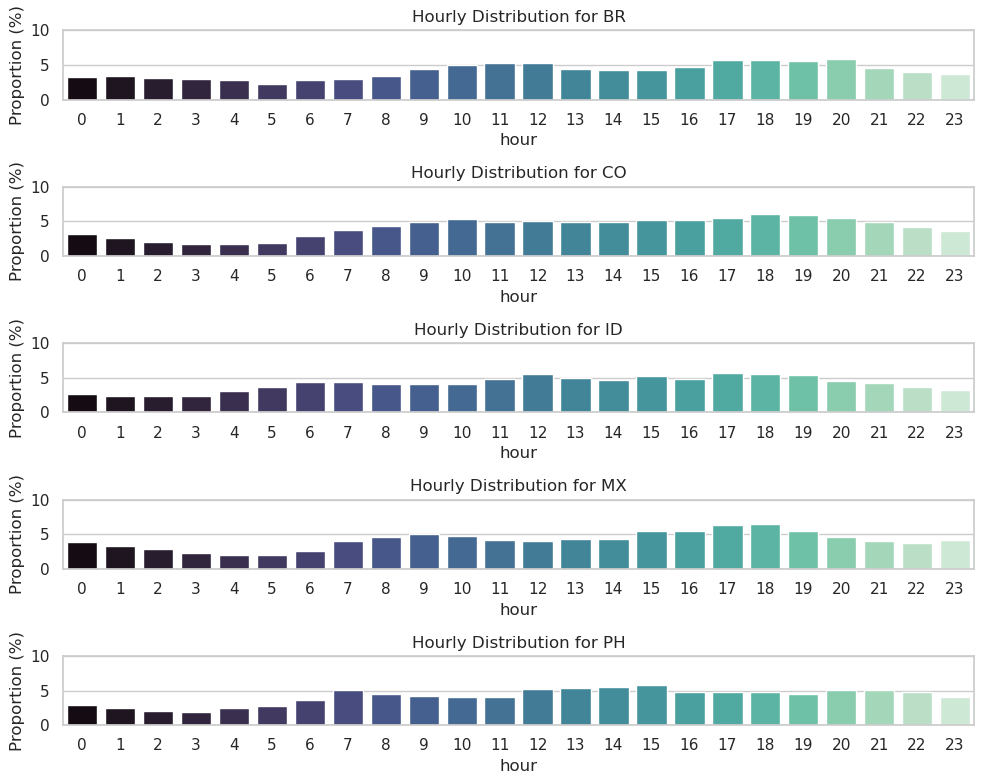

In [13]:
df['hour'] = [x.hour for x in df.local_datetime]

# Set the order of countries
country_order = ["BR", "CO", "ID", "MX", "PH"]

# Set the aesthetics for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a subplot for each country
for i, country in enumerate(country_order, 1):
    plt.subplot(len(country_order), 1, i)
    df_country = df[df['country'] == country]
    sns.barplot(x='hour', y='hour', data=df_country, estimator=lambda x: len(x) / len(df_country) * 100, errorbar=None, palette='mako')
    plt.ylabel('Proportion (%)')
    plt.title(f'Hourly Distribution for {country}')
    plt.ylim(0, 10)  # Optional: set the same y-axis scale for all plots

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
spark_df = spark.createDataFrame(df)

In [15]:
pings = (spark_df)

In [16]:
sl = wbgps.get_stop_location(pings, "uid", "epoch_time")

In [17]:
make_list = wbgps.create_date_list()

/usr/local/spark/python/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
#split stop location that span mutiple days into single days
sl = (sl
      .withColumn("total_duration_stop_location", F.col("t_end") - F.col("t_start"))
      .withColumn('my_list', make_list(F.to_timestamp(F.col('t_start')), F.to_timestamp(F.col('t_end'))))
      .drop('t_start', 't_end')
      .withColumn("tmp", F.explode("my_list"))
      .withColumn("t_start", F.col("tmp").t_start)
      .withColumn("t_end", F.col("tmp").t_end)
      .drop("tmp", "my_list")
      .withColumn("duration", F.col("t_end") - F.col("t_start")))

In [19]:
df_l = sl.withColumn("t_start_hour", F.hour( F.to_timestamp("t_start"))).withColumn("t_end_hour", F.hour( F.to_timestamp("t_end"))).withColumn('weekday', F.dayofweek( F.to_timestamp("t_start"))).withColumn("date", F.to_timestamp("t_start")).withColumn("date_trunc", F.date_trunc("day", F.col("date")))

df_l = df_l.withColumn('total_pings_stop', F.col("total_pings_stop") + 1) # temporary fix, remove it for the next runs!!!

df_l = df_l.withColumn('geom_id',F.lit('ageomid'))

In [20]:
home_labels_df = wbgps.get_labels_home(df_l, start_hour_day, end_hour_day, min_pings_home_cluster_label, work_activity_average, home_period_window, min_periods_over_window)

In [21]:
all_labels_df = wbgps.get_labels_work(home_labels_df, start_hour_day, end_hour_day, min_pings_home_cluster_label, work_activity_average, work_period_window, min_periods_over_window_work)

In [22]:
labels = all_labels_df.toPandas()

In [23]:
labels.location_type.unique()

array(['O', 'H', 'W'], dtype=object)

In [24]:
labels_h = labels[labels["location_type"] == "H"]
labels_o = labels[labels["location_type"] == "O"]
labels_w = labels[labels["location_type"] == "W"]

# Time at location by time and day of the week

## Home

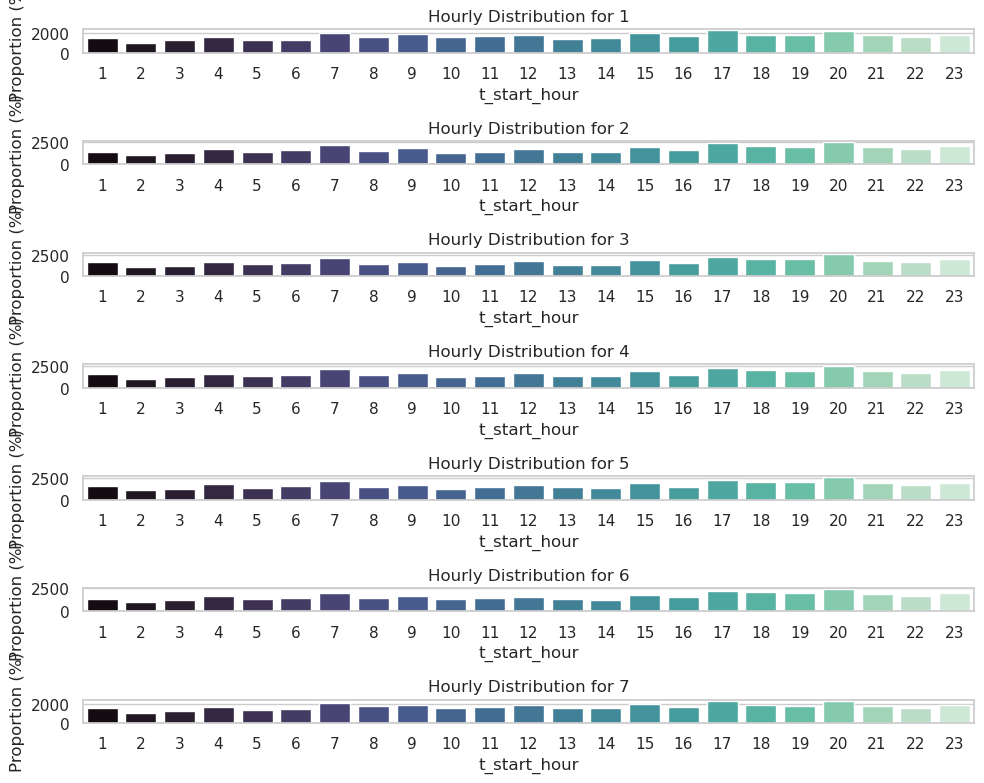

In [25]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a subplot for each country
for i, weekday in enumerate(np.arange(1,8), 1):
    plt.subplot(7, 1, i)
    df_country = labels_h[labels_h['weekday'] == weekday]
    sns.barplot(x='t_start_hour', y='t_start_hour', data=df_country.loc[df_country["t_start_hour"]!=0], estimator=lambda x: len(x), errorbar=None, palette='mako')
    plt.ylabel('Proportion (%)')
    plt.title(f'Hourly Distribution for {weekday}')
    # plt.ylim(0, 7)  # Optional: set the same y-axis scale for all plots

# Adjust layout
plt.tight_layout()
plt.show()


## Work

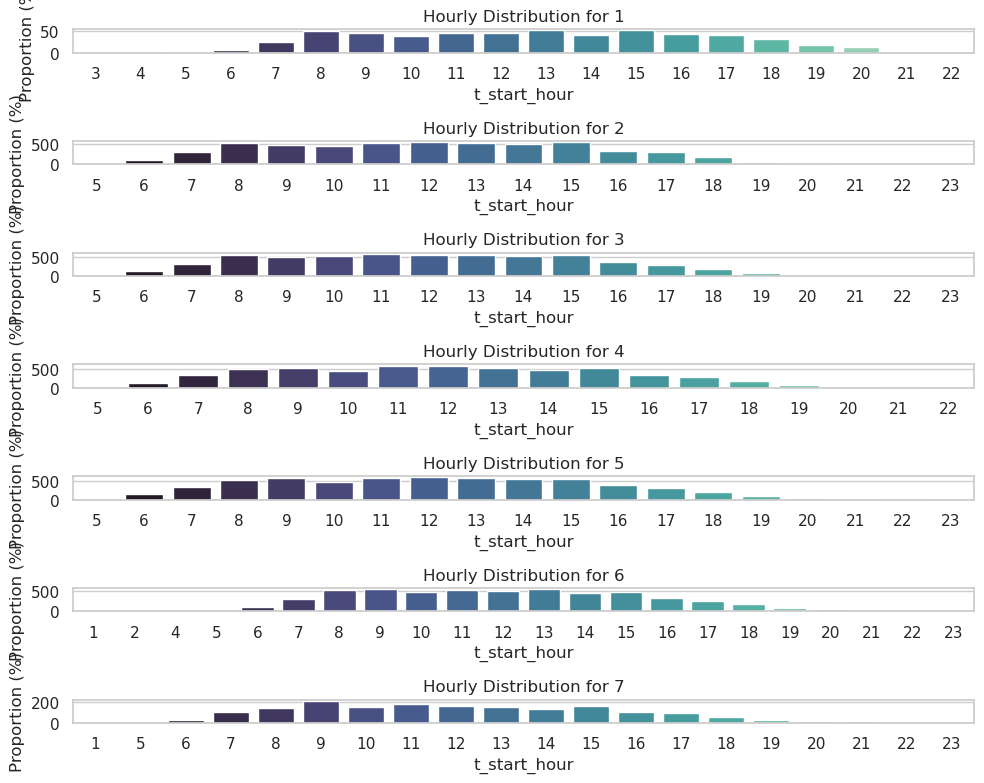

In [26]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a subplot for each country
for i, weekday in enumerate(np.arange(1,8), 1):
    plt.subplot(7, 1, i)
    df_country = labels_w[labels_w['weekday'] == weekday]
    sns.barplot(x='t_start_hour', y='t_start_hour', data=df_country.loc[df_country["t_start_hour"]!=0], estimator=lambda x: len(x), errorbar=None, palette='mako')
    plt.ylabel('Proportion (%)')
    plt.title(f'Hourly Distribution for {weekday}')
    # plt.ylim(0, 7)  # Optional: set the same y-axis scale for all plots

# Adjust layout
plt.tight_layout()
plt.show()


## Other

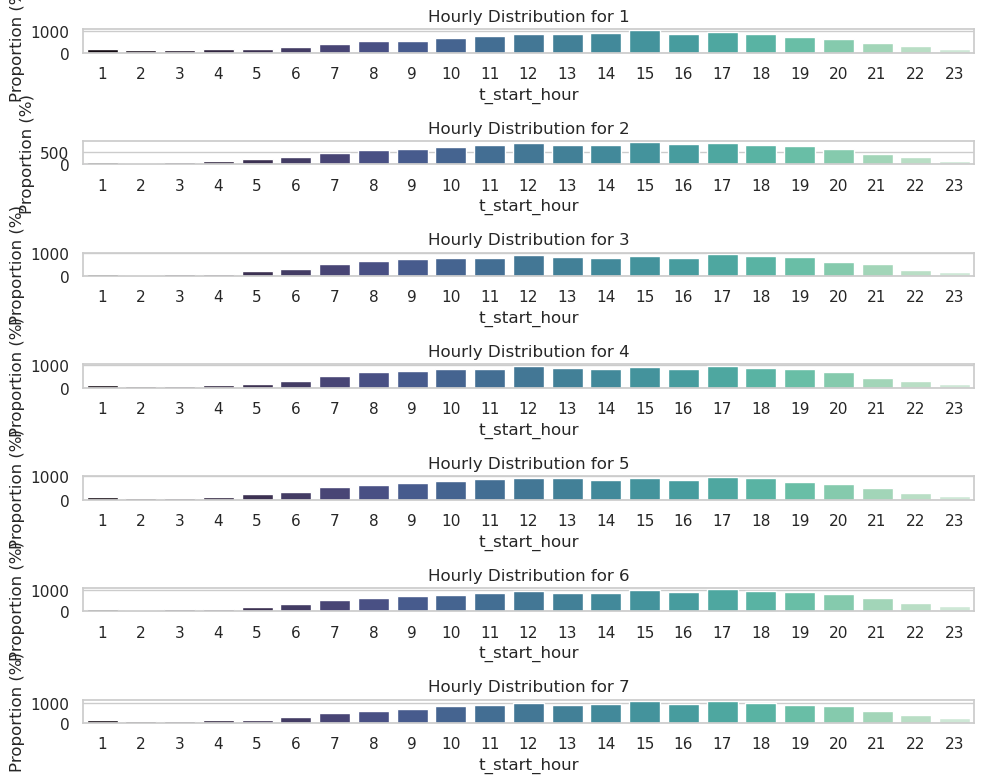

In [27]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a subplot for each country
for i, weekday in enumerate(np.arange(1,8), 1):
    plt.subplot(7, 1, i)
    df_country = labels_o[labels_o['weekday'] == weekday]
    sns.barplot(x='t_start_hour', y='t_start_hour', data=df_country.loc[df_country["t_start_hour"]!=0], estimator=lambda x: len(x), errorbar=None, palette='mako')
    plt.ylabel('Proportion (%)')
    plt.title(f'Hourly Distribution for {weekday}')
    # plt.ylim(0, 7)  # Optional: set the same y-axis scale for all plots

# Adjust layout
plt.tight_layout()
plt.show()
